Урок 8. 
Python применение статистических критериев на практике - пайплайн оценки A/B
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [52]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [53]:

import warnings

warnings.filterwarnings('ignore')
data = pd.read_excel('C:/GB/Analyst/AB_test/HW/8/AB_Test_Results.xlsx')

In [54]:
data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [56]:
data['REVENUE'].value_counts().sort_index()

0.00      9848
0.02         3
0.04         5
0.06         1
0.23         1
          ... 
29.32        1
41.53        1
57.46        1
58.63        1
196.01       1
Name: REVENUE, Length: 101, dtype: int64

Посмотрим, есть ли юзеры, присутствующие в обеих группах?

In [57]:
A_and_B = data.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
A_and_B

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


Да, мы видим ID юзеров, присутствующих в обеих группах. Возьмеме только пользователей, присутсвующих только в одной группе.

In [58]:
A_or_B = A_and_B.query('VARIANT_NAME < 2')

In [59]:
data_new = data[data.USER_ID.isin(A_or_B.USER_ID)]
data_new.shape

(6070, 3)

In [60]:
data_new['USER_ID'].value_counts()

5652    6
1339    5
1782    5
9152    4
8573    4
       ..
9730    1
2924    1
293     1
9670    1
9468    1
Name: USER_ID, Length: 4783, dtype: int64

Мы видим, что остались повторения ID внутри групп, но их мы оставим, так как весь принесенный ими доход находится в одной группе. Делим пользователей на две группы, удаляя тех, которые не принесли доход.

In [61]:
data_A=data_new[(data_new.VARIANT_NAME=='control')&(data_new.REVENUE>0)]
data_B=data_new[(data_new.VARIANT_NAME=='variant')&(data_new.REVENUE>0)]

In [62]:
data_A.describe()

,USER_ID,REVENUE
count,54.000000,54.000000
mean,4283.851852,8.714074
std,2846.713818,26.627446
min,124.000000,0.020000
25%,1947.500000,1.585000
50%,3617.500000,3.120000
75%,6458.250000,6.007500
max,9766.000000,196.010000


In [63]:
data_B.describe()

,USER_ID,REVENUE
count,43.000000,43.000000
mean,5297.534884,4.170233
std,3067.761518,4.932851
min,56.000000,0.020000
25%,3328.500000,1.250000
50%,4995.000000,2.720000
75%,8011.000000,4.270000
max,9928.000000,23.040000


Предварительно можно сказать, что среднее значение в группе А в два раза больше, чем в группе В, максимальное значение в группе А больше чем в В в 8,5 раз. Нужно посмотреть на выбросы.Построим гистограммы.

<Axes: xlabel='REVENUE', ylabel='Count'>

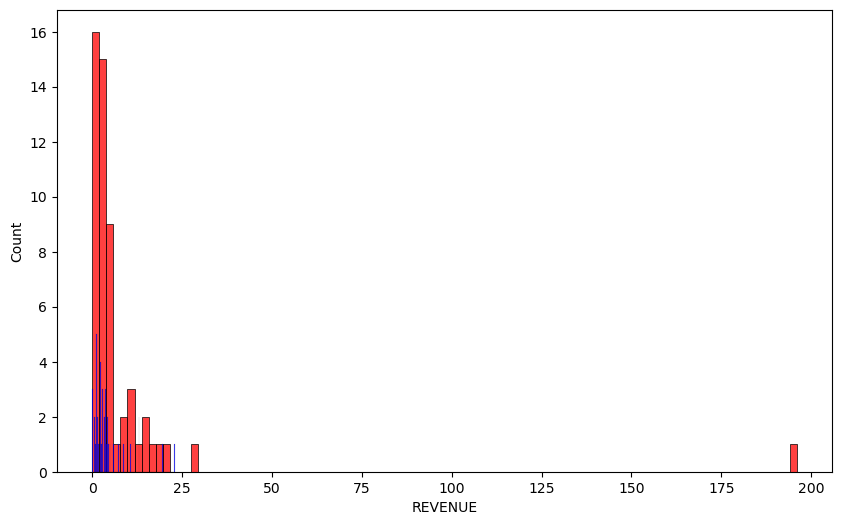

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(data_A['REVENUE'], color='r', bins=100)
sns.histplot(data_B['REVENUE'], color='b', bins=100)

Посмотрим выбросы:

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

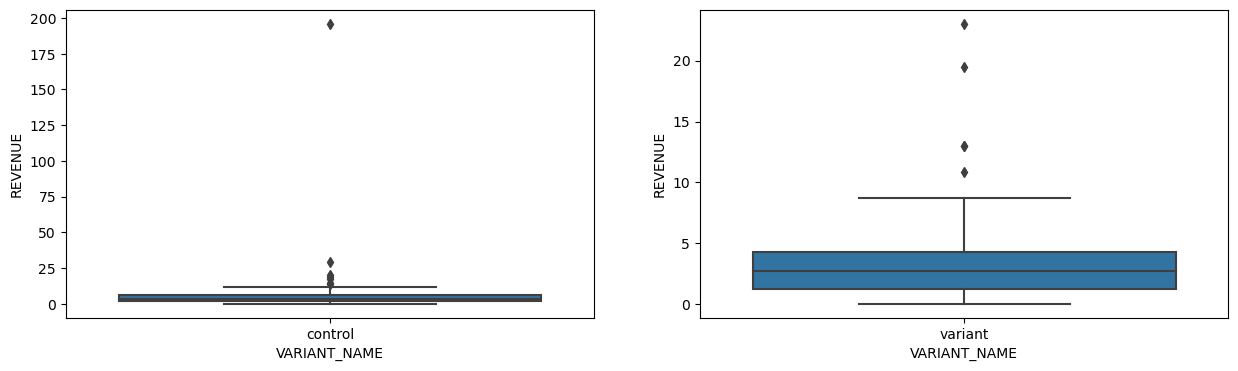

In [65]:
fig, (ax_boxplot, bx_boxplot) = plt.subplots(1, 2, figsize=(15,4))
sns.boxplot(x=data_A['VARIANT_NAME'], y=data_A['REVENUE'], ax=ax_boxplot)
sns.boxplot(x=data_B['VARIANT_NAME'], y=data_B['REVENUE'])

In [66]:
data_A['REVENUE'].value_counts().sort_index().tail()

17.05     1
18.56     1
20.07     1
29.32     1
196.01    1
Name: REVENUE, dtype: int64

Видим, что в группе А есть одно значение 196, при том, что основная масса  REVENUE лежит до 30, я бы убрала это значение. В группе В таких выбросов нет, убирать ничего не будем.

In [67]:
data_A2 = data_A[data_A['REVENUE'] < data_A['REVENUE'].quantile(0.975)]

<Axes: ylabel='Count'>

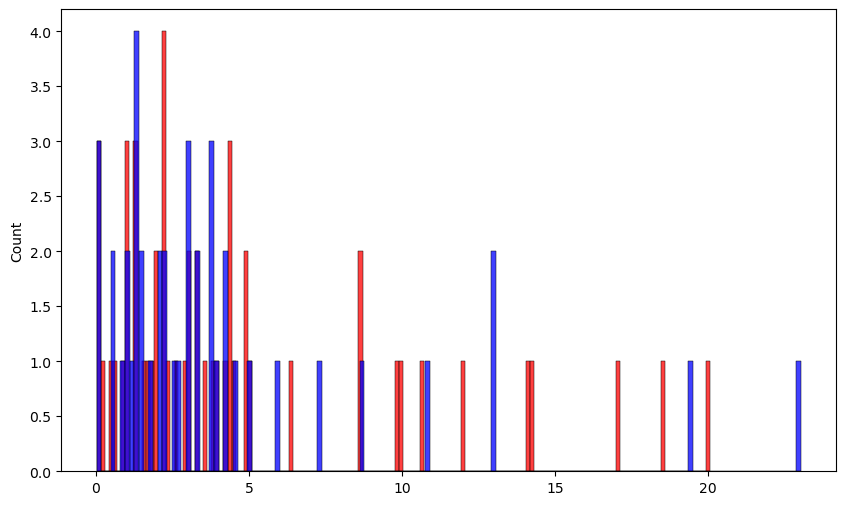

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(data_A2['REVENUE'].values, color ='r', bins=150)
sns.histplot(data_B['REVENUE'].values, color ='b', bins=150)

In [69]:
data_A2.describe()

,USER_ID,REVENUE
count,52.000000,52.000000
mean,4342.692308,4.715962
std,2883.176017,4.935908
min,124.000000,0.020000
25%,1925.000000,1.482500
50%,3772.000000,2.990000
75%,6506.750000,4.957500
max,9766.000000,20.070000


In [70]:
data_B.describe()

,USER_ID,REVENUE
count,43.000000,43.000000
mean,5297.534884,4.170233
std,3067.761518,4.932851
min,56.000000,0.020000
25%,3328.500000,1.250000
50%,4995.000000,2.720000
75%,8011.000000,4.270000
max,9928.000000,23.040000


Здесь мы уже видим похожие значения во всех полях, можно предварительно предположить, что статистически значимых рахличий мы не найдем. Очивидно, что данные распределены ненормально, но проверим это на всякий случай.

In [71]:
stats.shapiro(data_A['REVENUE'])

ShapiroResult(statistic=0.2597762942314148, pvalue=5.154708786008454e-15)

In [72]:
stats.shapiro(data_B['REVENUE'])

ShapiroResult(statistic=0.705331027507782, pvalue=5.565184935107936e-08)

Тест доказал, что распределние ненормальное. В следсчии этого, и учитывая, что данные количественные и выборки независимые используем критерий Манна-Уитни для оценки статистической разницы значения REVENUE в двух группах:

In [73]:
statistic, pvalue=stats.mannwhitneyu(data_A['REVENUE'].values, data_B['REVENUE'].values)
print (f'statistic = {statistic}, p-value = {round(pvalue, 3)}')
if (pvalue<0.05): print('Статистические различия обнаружены, принимаем альтернативную гипотезу.')
if (pvalue>0.05): print('Статистические различия не обнаружены, принимаем нулевую гипотезу.')

statistic = 1292.0, p-value = 0.343
Статистические различия не обнаружены, принимаем нулевую гипотезу.


Посмотрим, есть ли статистическая разница в количестве пользователей, совершивших покупку по отношению к общему количеству пользователей. Так как распределение ненормальное, используем критерий хи-квадрат.

In [77]:
all_A=data_new[data_new['VARIANT_NAME']=='control'].shape[0]
all_B=data_new[data_new['VARIANT_NAME']=='variant'].shape[0]
A=data_A.shape[0]
B=data_B.shape[0]
all_A, all_B, A, B

(3026, 3044, 54, 43)

In [85]:
statistic, pvalue,_ , _=stats.chi2_contingency([[A, all_A-A], [B, all_B-B]], correction=False)
print (f'statistic = {statistic}, p-value = {round(pvalue, 3)}')
if (pvalue<0.05): print('Статистические различия обнаружены, принимаем альтернативную гипотезу.')
if (pvalue>0.05): print('Статистические различия не обнаружены, принимаем нулевую гипотезу.')

statistic = 1.3348574212727065, p-value = 0.248
Статистические различия не обнаружены, принимаем нулевую гипотезу.


И в значениях REVENUEб и в количестве пользователей, совершивших покупку на основе данных выборок статистических различий между группами А и В не обнаружено. На данном этапе запускать вариант В не нужно. Возможно, пока недостаточное количество пользователей в выборках.